In [52]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda, BatchNormalization
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from scipy.special import rel_entr


In [53]:
train_data = pd.read_csv("../data/interim/split/z_sorted_train_data_mm.csv",)
test_data = pd.read_csv("../data/interim/split/z_sorted_test_data_mm.csv")
val_data = pd.read_csv("../data/interim/split/z_sorted_val_data_mm.csv")



In [54]:
train_data_array = train_data.values
test_data_array = test_data.values
val_data_array = val_data.values

In [55]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = gumbel_sample((batch, dim))
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return {}

    @classmethod
    def from_config(cls, config):
        return cls()

In [56]:
latent_dim = 64
encoder_inputs = Input(shape=(31), name="input_layer")

n_x1 = 512
x = Dense(n_x1, activation="relu", name="h1")(encoder_inputs)
x = BatchNormalization(name="batch1")(x)
n_x2 = 256
x = Dense(n_x2, activation="relu", name="h2")(x)

# Split x3 into two halves
half_size = n_x2 // 2
x1_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x)
x1_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x)

z_mean = Dense(latent_dim, name="z_mean")(x1_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x1_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 31)]         0           []                               
                                                                                                  
 h1 (Dense)                     (None, 512)          16384       ['input_layer[0][0]']            
                                                                                                  
 batch1 (BatchNormalization)    (None, 512)          2048        ['h1[0][0]']                     
                                                                                                  
 h2 (Dense)                     (None, 256)          131328      ['batch1[0][0]']                 
                                                                                            

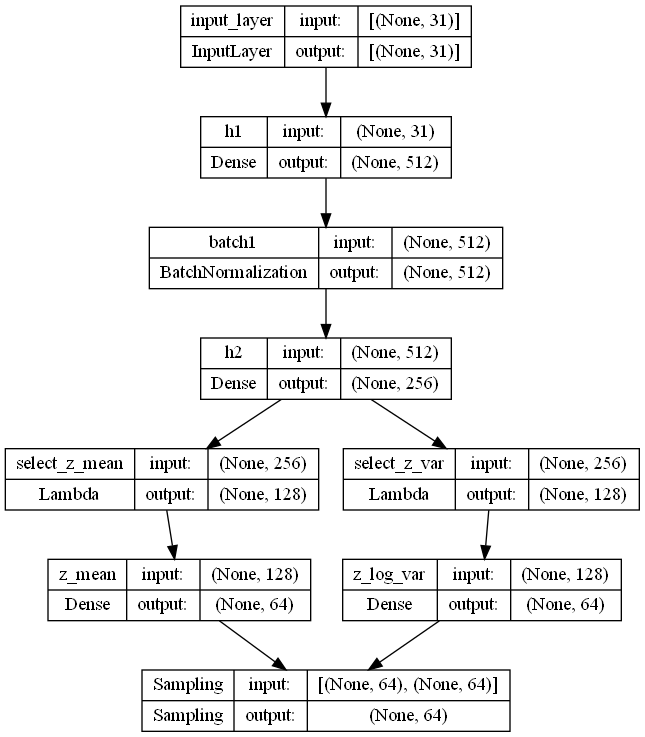

In [57]:
keras.utils.plot_model(encoder, show_shapes=True)

In [58]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
n_x3 = 64
x = Dense(n_x3, activation="relu", name="h4")(latent_inputs)
x = BatchNormalization(name="batch1")(x)
cont_decoder_outputs = Dense(30, activation = 'linear', name="cont_decoder_output")(x)
class_decoder_output = Dense(1, activation="sigmoid", name="classification_output")(x)
decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 h4 (Dense)                     (None, 64)           4160        ['input_4[0][0]']                
                                                                                                  
 batch1 (BatchNormalization)    (None, 64)           256         ['h4[0][0]']                     
                                                                                                  
 cont_decoder_output (Dense)    (None, 30)           1950        ['batch1[0][0]']                 
                                                                                            

In [59]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reconstruction_loss_class_tracker = keras.metrics.Mean(
            name="reconstruction_loss_class"
        )
        self.mean_abs_diff_cont_tracker = keras.metrics.Mean(name='mean_abs_diff_cont')
        self.mean_abs_diff_class_tracker = keras.metrics.Mean(name='mean_abs_diff_class')
        self.mean_binary_tracker = keras.metrics.Mean(name="mean_binary_value")
        self.kl_div_tracker = keras.metrics.Mean(name='kl_divergence')

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update(
            {
                "encoder": self.encoder,
                "decoder": self.decoder,
            }
        )
        return config

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.reconstruction_loss_class_tracker,

        ]

    def call(self, inputs):
        return self.decoder(self.encoder(inputs)[2])

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)

            reconstruction_cont, reconstruction_class = self.decoder(z)
            # latent_vectors = np.random.normal(scale=1, size=(32, latent_dim))
            # reconstruction_cont, reconstruction_class = self.decoder(latent_vectors)

            data_cont = data[:, :30]  
            data_class = data[:, 30:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.binary_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Compute the KL Div between original data and reconstructed
            kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

            # Combine losses
            total_loss = (
                reconstruction_loss_cont + 10 * reconstruction_loss_class + kl_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.kl_div_tracker.update_state(kl_div)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "sparse_categorical_crossentropy": self.reconstruction_loss_class_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]  # Unpack the tuple and take the input data

        data_cont = data[:, :30]  # Assuming the first 4 columns are for continuous variables
        data_class = data[:, 30:]  # Assuming the last column is for classification

        z_mean, z_log_var, z = self.encoder(data)
        # len_data = data.shape[0]

        latent_vectors = np.random.normal(scale=1, size=(32, latent_dim))
        reconstruction_cont, reconstruction_class = self.decoder(latent_vectors)

        reconstruction_loss_cont = keras.losses.mean_squared_error(
            data_cont, reconstruction_cont
        )

        # Reconstruction loss for classification output
        reconstruction_loss_class =  keras.losses.binary_crossentropy(
            data_class, reconstruction_class
        )

        kl_loss = -0.5 * (
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        kl_loss = tf.reduce_mean(kl_loss, axis=1)

        # Combine losses
        total_loss = (
            reconstruction_loss_cont + 10 * reconstruction_loss_class + kl_loss
        )

        # Compute mean absolute differences and mean of binary data
        mean_abs_diff_cont = tf.reduce_mean(tf.abs(data_cont - reconstruction_cont))
        mean_abs_diff_class = tf.reduce_mean(tf.abs(data_class - reconstruction_class))
        mean_binary_value = tf.reduce_mean(tf.cast(reconstruction_class >= 0.5, tf.float32))

        # Compute the KL Div between original data and reconstructed
        kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

        # Update the loss tracker
        self.total_loss_tracker.update_state(total_loss)

        # Update other metrics
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.mean_abs_diff_cont_tracker.update_state(mean_abs_diff_cont)
        self.mean_abs_diff_class_tracker.update_state(mean_abs_diff_class)
        self.mean_binary_tracker.update_state(mean_binary_value)
        self.kl_div_tracker.update_state(kl_div)

        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mean_abs_diff_cont": self.mean_abs_diff_cont_tracker.result(),
            "mean_abs_diff_class": self.mean_abs_diff_class_tracker.result(),
            "mean_binary_value": self.mean_binary_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }

In [60]:
from keras.optimizers import Adam

vae = VAE(encoder, decoder)


# Define your learning rate
learning_rate = 0.0001 

# Create Adam optimizer with the specified learning rate
adam_optimizer = Adam(lr=learning_rate)

# Compile your VAE model with the Adam optimizer
vae.compile(optimizer=adam_optimizer)

c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [61]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights to the best model observed during training
)

# # Define the directory to save the model
# model_dir = "saved_model/"

# # Define a TensorBoard callback for training logs
# tensorboard_callback = TensorBoard(log_dir="logs/vae_optimized_263")

# # Define a ModelCheckpoint callback to save the model
# checkpoint_callback = ModelCheckpoint(
#     filepath=model_dir, save_best_only=True, monitor="val_loss", mode="min"
# )
#tensorboard_callback
call_back_list = [early_stopping_callback]

hist = vae.fit(
    train_data_array,
    epochs=20,
    batch_size=32,
    validation_data=(val_data_array, None), 
    callbacks=call_back_list,
)

Epoch 1/20
6231/6231 [==============================] - 21s 3ms/step - loss: 1.6703 - reconstruction_loss_cont: 0.9754 - reconstruction_loss_class: 0.0134 - kl_loss: 0.2768 - sparse_categorical_crossentropy: 0.0434 - kl_div: 48.9173 - val_loss: 2.9536 - val_reconstruction_loss_cont: 1.3130 - val_reconstruction_loss_class: 0.1358 - val_kl_loss: 0.2830 - val_mean_abs_diff_cont: 0.8247 - val_mean_abs_diff_class: 0.1059 - val_mean_binary_value: 0.0625 - val_kl_div: 41.4559
Epoch 2/20
6231/6231 [==============================] - 19s 3ms/step - loss: 0.7257 - reconstruction_loss_cont: 0.4066 - reconstruction_loss_class: 0.0019 - kl_loss: 0.2877 - sparse_categorical_crossentropy: 0.0026 - kl_div: 36.2891 - val_loss: 2.0633 - val_reconstruction_loss_cont: 1.3580 - val_reconstruction_loss_class: 0.0434 - val_kl_loss: 0.2712 - val_mean_abs_diff_cont: 0.8331 - val_mean_abs_diff_class: 0.0686 - val_mean_binary_value: 0.0312 - val_kl_div: 34.8041
Epoch 3/20
6231/6231 [==============================

# Synth Data Creation

In [62]:
# synth Data from Data random sample
latent_vectors = np.random.normal(scale=1, size=(len(test_data_array), latent_dim))
generated_data_cont_from_sample, generated_data_class_from_sample = vae.decoder.predict(latent_vectors)

1781/1781 [==============================] - 2s 1ms/step


Saving the synth data from sample

In [63]:
binary_predictions_from_sample = (generated_data_class_from_sample >= 0.5).astype(int)
print(sum(binary_predictions_from_sample))

# Create DataFrame with synthetic data
synthetic_data_from_sample = pd.DataFrame(
    generated_data_cont_from_sample, columns=train_data.columns[:-1]
)
# Add binary_predictions as an additional column
synthetic_data_from_sample["Class"] = binary_predictions_from_sample
synthetic_data_from_sample.to_csv("../data/interim/synthdata_from_sample_small_extreme_high_class_10_loss_low_learning.csv", index=False)

[0]


In [64]:
# call_for_saving = vae(train_data_array[:1])
# vae.save("../models/VAE/optimized_for_sample", save_format="tf")

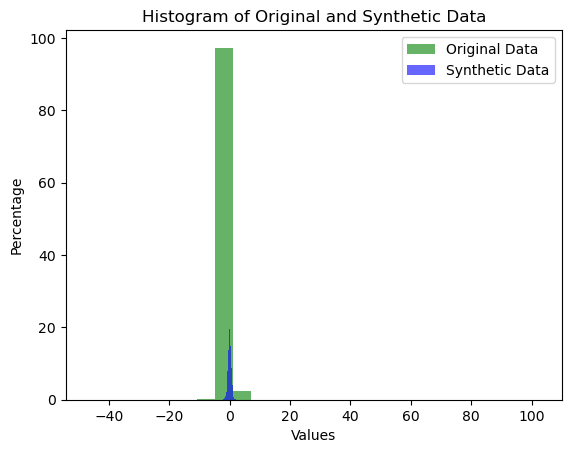

In [65]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
colum_num =28
original_column = train_data_array[:, colum_num]

synth_column = generated_data_cont_from_sample[:, colum_num]

# Calculate the percentage for original_column
total_points_original = len(original_column)
percentage_original = (original_column / total_points_original) * 100

# Calculate the percentage for synth_column
total_points_synth = len(synth_column)
percentage_synth = (synth_column / total_points_synth) * 100

# Plot histograms
plt.hist(
    original_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(original_column) / total_points_original * 100,
    label="Original Data",
)

plt.hist(
    synth_column,
    bins=25,
    color="b",
    alpha=0.6,
    weights=np.ones_like(synth_column) / total_points_synth * 100,
    label="Synthetic Data",
)

plt.title("Histogram of Original and Synthetic Data")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.legend()

plt.show()

In [66]:
# For each feature, create a histogram for the real and synthetic data
for feature in df_credit.columns[:-1]:
    
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(real_data[feature], bins=20, alpha=0.5, color="g", label="Real")
    plt.title(f"Real Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data[feature], bins=20, alpha=0.5, color="b", label="Synthetic")
    plt.title(f"Synthetic Data: {feature}")
    plt.legend()

    plt.show()

# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data:")
print(real_data.describe())
print("\nSummary statistics for the synthetic data:")
print(synthetic_data.describe())

plt.show()

NameError: name 'df_credit' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score




# Assuming the target variable is in the last column
X_train = train_data[:, :-1]  # Features for training
y_train = train_data[:, -1]  # Target variable for training

X_test = test_data[:, :-1]  # Features for testing
y_test = test_data[:, -1]  # Target variable for testing


# Step 3: Instantiate the model
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Step 4: Train the model
random_forest.fit(X_train, y_train)

# Step 5: Evaluate the model
train_accuracy = accuracy_score(y_train, random_forest.predict(X_train))
test_accuracy = accuracy_score(y_test, random_forest.predict(X_test))

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9998745987158909
Testing Accuracy: 0.9996488764044944


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Get predictions from the random forest model
predictions = random_forest.predict(generated_data_cont)

# Compute accuracy score
accuracy = accuracy_score(binary_predictions, predictions)
print("Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(
    predictions, binary_predictions
)

print("Confusion Matrix:")
print(cm)

Accuracy: 0.9990344440153085
Confusion Matrix:
[[56849    44]
 [   11    58]]
